# RNN Text Classification with Attention

This notebook implements a Bidirectional GRU with an attention mechanism for Amazon review sentiment classification (1-5 stars).

Key features:
- Bidirectional GRU with attention mechanism and L2-regularization
- 5-fold stratified cross-validation
- Ensemble predictions from all folds

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

I0000 00:00:1765282426.429598    1293 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765282426.935713    1293 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765282428.864439    1293 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.21.0-dev20251006
GPUs available: 1


W0000 00:00:1765282430.861379    1293 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


## Load Data

In [34]:
X_train = np.load('X_train.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)

df_train = pd.DataFrame(X_train, columns=['reviewerID', 'reviewText', 'summary'])
df_train['overall'] = y_train - 1  # Convert to 0-4
df_train['reviewText'] = df_train['reviewText'].fillna('').astype(str)
df_train['summary'] = df_train['summary'].fillna('').astype(str)

df_test = pd.DataFrame(X_test, columns=['reviewerID', 'reviewText', 'summary'])
df_test['reviewText'] = df_test['reviewText'].fillna('').astype(str)
df_test['summary'] = df_test['summary'].fillna('').astype(str)

print(f"Training samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")
print(f"\nClass distribution:\n{df_train['overall'].value_counts().sort_index()}")

Training samples: 30850
Test samples: 3428

Class distribution:
overall
0      985
1     1346
2     3496
3     7050
4    17973
Name: count, dtype: int64


## Configuration

In [40]:
# Hyperparameters - Ikke parametre, der gav 78%
MAX_TOKENS = 8500
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128
RNN_UNITS = 128
DROPOUT_RATE = 0.5
L2_REG = 0.0001
BATCH_SIZE = 1024
EPOCHS = 40
PATIENCE = 7
N_FOLDS = 5

## Prepare Text Data

In [41]:
# Combine review text and summary
df_train['combined_text'] = df_train['reviewText'] + ' ' + df_train['summary']
df_test['combined_text'] = df_test['reviewText'] + ' ' + df_test['summary']

X_full = df_train['combined_text'].values
y_full = df_train['overall'].values
X_test_full = df_test['combined_text'].values

print(f"Sample text: {X_full[0][:100]}...")

Sample text: One of my favorite perfumes and the fact that it is unisex is awesome. I'm gifting this for my nephe...


## Attention Layer

The attention mechanism learns to weight each timestep based on its importance for classification, rather than just using the final hidden state.

In [42]:
class Attention(tf.keras.layers.Layer):
    """
    Attention mechanism for sequence classification.
    Input: (batch_size, timesteps, features)
    Output: (batch_size, features) - weighted sum of all timesteps
    """
    
    def build(self, input_shape):
        self.features_dim = input_shape[-1]
        self.W = self.add_weight(name='attention_weight',
                                 shape=(self.features_dim, self.features_dim),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(self.features_dim,),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_context',
                                 shape=(self.features_dim, 1),
                                 initializer='glorot_uniform', trainable=True)
        super().build(input_shape)
    
    def call(self, x):
        # Compute attention scores: tanh(W * h + b)
        score = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        # Compute attention weights: softmax(score * u)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        # Weighted sum of hidden states
        return tf.reduce_sum(x * attention_weights, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

## Model Definition

In [43]:
def build_model():
    """Build Bidirectional GRU model with Attention."""
    inputs = tf.keras.Input(shape=(SEQUENCE_LENGTH,))
    
    # Embedding
    x = tf.keras.layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        embeddings_regularizer=tf.keras.regularizers.l2(L2_REG)
    )(inputs)
    
    # Spatial dropout
    x = tf.keras.layers.SpatialDropout1D(DROPOUT_RATE)(x)
    
    # Bidirectional GRU (return_sequences=True for attention)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            RNN_UNITS,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
        )
    )(x)
    
    # Attention
    x = Attention()(x)
    
    # Dropout and output
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Test build
test_model = build_model()
test_model.summary()
del test_model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 250, 128)       │     1,088,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 250, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 250, 256)       │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,353,477 (5.16 MB)

 Trainable params: 1,353,477 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

## Cross-Validation Training

In [44]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_scores = []
fold_histories = []
all_test_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full), 1):
    print(f"\n{'='*60}\nFOLD {fold}/{N_FOLDS}\n{'='*60}")
    
    # Split data
    X_train_fold, X_val_fold = X_full[train_idx], X_full[val_idx]
    y_train_fold, y_val_fold = y_full[train_idx], y_full[val_idx]
    print(f"Train: {len(X_train_fold)}, Val: {len(X_val_fold)}")
    
    # Create TextVectorization layer (fit on training data only)
    encoder = tf.keras.layers.TextVectorization(
        max_tokens=MAX_TOKENS,
        output_sequence_length=SEQUENCE_LENGTH,
        pad_to_max_tokens=True
    )
    encoder.adapt(tf.data.Dataset.from_tensor_slices(X_train_fold).batch(128))
    
    # Create datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(BATCH_SIZE)
    train_ds = train_ds.map(lambda x, y: (encoder(x), y)).cache().prefetch(tf.data.AUTOTUNE)
    
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(BATCH_SIZE)
    val_ds = val_ds.map(lambda x, y: (encoder(x), y)).cache().prefetch(tf.data.AUTOTUNE)
    
    test_ds = tf.data.Dataset.from_tensor_slices(X_test_full).batch(BATCH_SIZE)
    test_ds = test_ds.map(lambda x: encoder(x)).prefetch(tf.data.AUTOTUNE)
    
    # Build and compile model
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=PATIENCE, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
        )
    ]
    
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    
    # Store results
    val_score = max(history.history['val_accuracy'])
    fold_scores.append(val_score)
    fold_histories.append(history.history)
    print(f"\nFold {fold} Validation Accuracy: {val_score:.4f}")
    
    # Test predictions
    test_preds = model.predict(test_ds)
    all_test_preds.append(test_preds)
    
    # Clean up
    tf.keras.backend.clear_session()

print(f"\n{'='*60}")
print(f"CV Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")
print(f"{'='*60}")


FOLD 1/5
Train: 24680, Val: 6170
Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5698 - loss: 1.3532 - val_accuracy: 0.5827 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5826 - loss: 1.1564 - val_accuracy: 0.5827 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ -0s -12284us/step - accuracy: 0.5971 - loss: 1.0066 - val_accuracy: 0.6219 - val_loss: 0.9589 - learning_rate: 0.0010
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6427 - loss: 0.8983 - val_accuracy: 0.6425 - val_loss: 0.9313 - learning_rate: 0.0010
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6732 - loss: 0.8393 - val_accuracy: 0.6627 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7036 - loss: 0.7826 - val_accuracy: 0.6833 - val_loss: 0.8275 - learning_rate: 0.0010
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - ac

I0000 00:00:1765283589.413476    1293 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5649 - loss: 1.3495 - val_accuracy: 0.5827 - val_loss: 1.1865 - learning_rate: 0.0010
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5826 - loss: 1.1597 - val_accuracy: 0.5827 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5947 - loss: 1.0164 - val_accuracy: 0.6248 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.6364 - loss: 0.9156 - val_accuracy: 0.6468 - val_loss: 0.8903 - learning_rate: 0.0010
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.6618 - loss: 0.8603 - val_accuracy: 0.6592 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6860 - loss: 0.8136 - val_accuracy: 0.6809 - val_loss: 0.8300 - learning_rate: 0.0010
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7102 - loss: 0.7601 - val_accuracy: 0.70

## Plot Training History

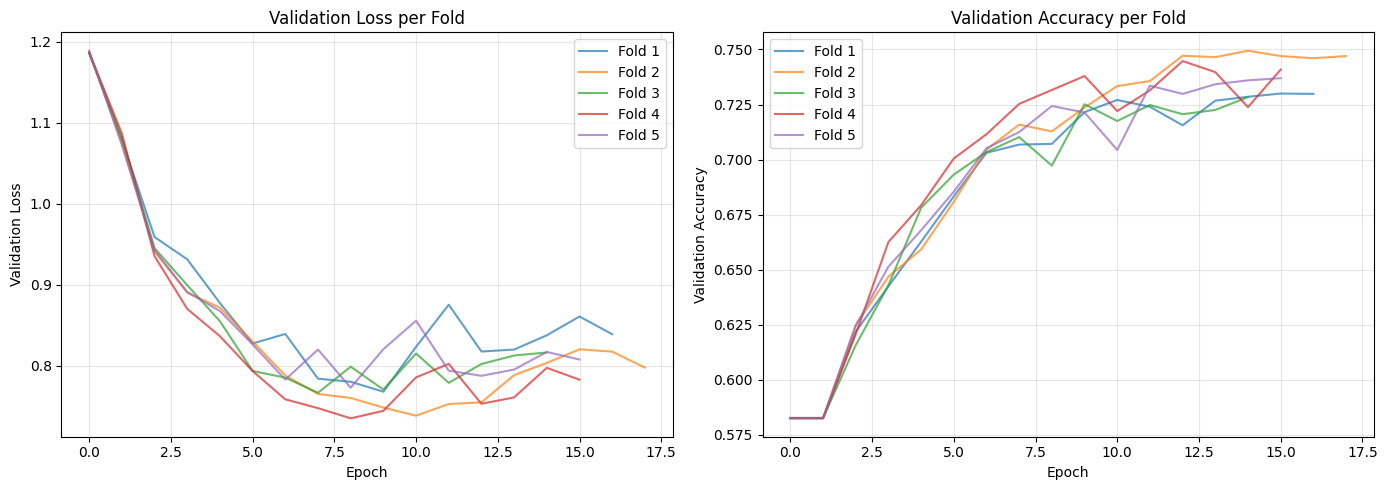

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, history in enumerate(fold_histories):
    axes[0].plot(history['val_loss'], label=f'Fold {i+1}', alpha=0.7)
    axes[1].plot(history['val_accuracy'], label=f'Fold {i+1}', alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Validation Loss per Fold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Validation Accuracy per Fold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cv_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## Ensemble Predictions

In [46]:
# Average probabilities across all folds
ensemble_preds = np.mean(all_test_preds, axis=0)
predicted_labels = np.argmax(ensemble_preds, axis=1) + 1  # Convert back to 1-5

print("Prediction distribution:")
unique, counts = np.unique(predicted_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count} ({count/len(predicted_labels)*100:.1f}%)")

Prediction distribution:
  Class 1: 116 (3.4%)
  Class 2: 2 (0.1%)
  Class 3: 406 (11.8%)
  Class 4: 802 (23.4%)
  Class 5: 2102 (61.3%)


## Save Submission

In [47]:
submission = pd.DataFrame({
    'Id': list(range(len(predicted_labels))),
    'Predicted': predicted_labels.reshape(-1),
})
submission.to_csv('y_test_hat.csv', index=False)

print(f"Submission saved to y_test_hat.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

Submission saved to y_test_hat.csv

First 10 predictions:
   Id  Predicted
0   0          5
1   1          5
2   2          5
3   3          3
4   4          5
5   5          5
6   6          5
7   7          3
8   8          3
9   9          4


## Summary

In [48]:
print(f"Model: Bidirectional GRU + Attention")
print(f"Embedding dim: {EMBEDDING_DIM}")
print(f"RNN units: {RNN_UNITS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"L2 regularization: {L2_REG}")
print(f"\nCV Mean Accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

Model: Bidirectional GRU + Attention
Embedding dim: 128
RNN units: 128
Dropout: 0.5
L2 regularization: 0.0001

CV Mean Accuracy: 0.7379 (+/- 0.0082)
